In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [77]:
train_data = pd.read_csv('compas_dataset/propublicaTrain.csv')
test_data = pd.read_csv('compas_dataset/propublicaTest.csv')

In [3]:
train_data

,two_year_recid,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_F,c_charge_degree_M
0,0,1,64,0,0,0,0,13,0,1
1,0,1,28,0,0,0,0,1,1,0
2,0,1,32,0,0,0,0,1,1,0
3,1,1,20,0,0,1,1,2,1,0
4,0,1,43,1,0,0,0,8,1,0
...,...,...,...,...,...,...,...,...,...,...
4162,1,1,35,1,0,0,0,2,0,1
4163,0,0,24,1,0,0,0,1,1,0
4164,1,1,34,1,0,0,0,2,1,0
4165,0,1,45,0,0,0,0,0,0,1


In [78]:
test_data

,two_year_recid,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_F,c_charge_degree_M
0,1,1,27,1,0,0,1,18,1,0
1,1,0,29,1,0,0,0,11,1,0
2,1,1,25,1,0,0,1,6,0,1
3,0,1,26,1,1,0,0,2,1,0
4,0,0,33,1,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...
1995,0,1,30,0,0,0,0,0,0,1
1996,1,1,32,0,0,0,0,6,0,1
1997,1,1,46,1,0,0,0,1,0,1
1998,0,0,46,1,0,0,0,0,0,1


In [11]:
# pdf of multivariate guassian distribution
def multivariate_gaussian_pdf(x, mean, covariance_matrix):
    return (1 / (np.power(np.pi, len(x) / 2) * np.sqrt(np.linalg.det(covariance_matrix)))) * (np.exp(-(0.5) * np.dot(np.dot((x - mean).T, np.linalg.inv(covariance_matrix)), (x - mean))))

def MLE_classifier():
    train_data = pd.read_csv('compas_dataset/propublicaTrain.csv')
    test_data = pd.read_csv('compas_dataset/propublicaTest.csv')

    X_train = train_data.drop('two_year_recid', axis=1).to_numpy()
    X_test = test_data.drop('two_year_recid', axis=1).to_numpy()

    y_train = train_data['two_year_recid'].to_numpy()
    y_test = test_data['two_year_recid'].to_numpy()

    num_classes = len(set(y_train))

    # Assign class priors (for 0 and 1)
    class_priors = {}
    for i in range(num_classes):
        class_priors[i] = np.count_nonzero(y_train == i) / len(y_train)
    
    # Calculate MLE estimates for mean and covariance of each class
    class_means = {}
    class_covariances = {}
    for i in range(num_classes):
        class_means[i] = np.mean(X_train[y_train == i], axis=0)
        class_covariances[i] = np.cov(X_train[y_train == i], rowvar=False)

    # Evaluate model
    class_probs = []
    for x_test in X_test:
        probs = []
        for i in range(num_classes):
            class_conditional = multivariate_gaussian_pdf(x_test, class_means[i], class_covariances[i] + (1e-4 * np.identity(len(x_test))))
            probs.append(class_priors[i] * class_conditional)

        class_probs.append(probs)
    
    y_pred = np.argmax(class_probs, axis=1)
    accuracy = np.mean(y_pred == y_test)

    #print(accuracy)
    return accuracy

MLE_classifier()

0.635

In [16]:
# metric = L1, L2, or L-inf
# p = 1, 2, inf (L1, L2, L-inf)
from scipy.spatial.distance import cdist

def normed_distance(x1, x2, p=2.): 
    if p == 'inf':
        return cdist(x1, x2, metric='chebyshev')
    
    return cdist(x1, x2, metric='minkowski', p=p)

def kNN_classifier(k, metric='L1'):
    train_data = pd.read_csv('compas_dataset/propublicaTrain.csv')
    test_data = pd.read_csv('compas_dataset/propublicaTest.csv')

    X_train = train_data.drop('two_year_recid', axis=1).to_numpy()
    X_test = test_data.drop('two_year_recid', axis=1).to_numpy()

    y_train = train_data['two_year_recid'].to_numpy()
    y_test = test_data['two_year_recid'].to_numpy()

    # Normalize data (min-max)
    min_vals = np.min(X_train, axis=0)
    max_vals = np.max(X_train, axis=0)
    
    # Apply the same scaling to the test data
    X_train_normalized = (X_train - min_vals) / (max_vals - min_vals)
    X_test_normalized = (X_test - min_vals) / (max_vals - min_vals)

    # Distance metric
    p = 2
    if metric == 'L1':
        p = 1
    elif metric == 'L2':
        p = 2
    elif metric == 'L-inf':
        p = 'inf'

    y_pred = []
    for x in X_test_normalized:
        k_neighbors = None

        #dists = np.array([normed_distance(x, y) for y in X_train_normalized])
        dists = normed_distance(x.reshape(1, -1), X_train_normalized, p)[0]
        k_neighbor_indices = np.argsort(dists)[:k]
        k_neighbor_labels = y_train[k_neighbor_indices]

        y_pred.append(np.bincount(k_neighbor_labels).argmax())
    
    return np.mean(y_pred == y_test)

for i in range(5, 100, 5):
    print('L2', i, kNN_classifier(i, metric='L2'))
        

L2 5 0.6345
L2 10 0.6585
L2 15 0.6685
L2 20 0.676
L2 25 0.677
L2 30 0.6765
L2 35 0.6775
L2 40 0.682
L2 45 0.682
L2 50 0.684
L2 55 0.6845
L2 60 0.6875
L2 65 0.687
L2 70 0.6845
L2 75 0.6815
L2 80 0.6815
L2 85 0.6825
L2 90 0.688
L2 95 0.6875


In [17]:
for i in range(5, 100, 5):
    print('L1', i, kNN_classifier(i, metric='L1'))

L1 5 0.6505
L1 10 0.6625
L1 15 0.669
L1 20 0.6745
L1 25 0.678
L1 30 0.679
L1 35 0.681
L1 40 0.6745
L1 45 0.6835
L1 50 0.6855
L1 55 0.6795
L1 60 0.6805
L1 65 0.6845
L1 70 0.6775
L1 75 0.677
L1 80 0.6785
L1 85 0.6775
L1 90 0.6775
L1 95 0.679


In [18]:
for i in range(5, 100, 5):
    print('L-inf', i, kNN_classifier(i, metric='L-inf'))

L-inf 5 0.637
L-inf 10 0.658
L-inf 15 0.6745
L-inf 20 0.667
L-inf 25 0.6795
L-inf 30 0.679
L-inf 35 0.6785
L-inf 40 0.6735
L-inf 45 0.683
L-inf 50 0.6815
L-inf 55 0.683
L-inf 60 0.681
L-inf 65 0.6805
L-inf 70 0.6805
L-inf 75 0.6755
L-inf 80 0.682
L-inf 85 0.685
L-inf 90 0.686
L-inf 95 0.683


In [44]:
def naive_bayes_classifier():
    train_data = pd.read_csv('compas_dataset/propublicaTrain.csv')
    test_data = pd.read_csv('compas_dataset/propublicaTest.csv')

    # Encode continous variables into categorical variables using ranges (histograms)
    train_data['age'] = pd.qcut(train_data['age'], 10)
    train_data['juv_fel_count'] = pd.cut(train_data['juv_fel_count'], 6)
    #train_data['juv_misd_count'] = pd.cut(train_data['juv_misd_count'], 6)
    #train_data['juv_other_count'] = pd.cut(train_data['juv_other_count'], 6)
    train_data['priors_count'] = pd.cut(train_data['priors_count'], 20)

    X_train = train_data.drop('two_year_recid', axis=1).to_numpy()
    X_test = test_data.drop('two_year_recid', axis=1).to_numpy()

    y_train = train_data['two_year_recid'].to_numpy()
    y_test = test_data['two_year_recid'].to_numpy()

    class_prior_0 = np.count_nonzero(y_train == 0)/ len(y_train)
    class_prior_1 = np.count_nonzero(y_train == 1) / len(y_train)

    class_0_num = np.count_nonzero(y_train == 0)
    class_1_num = np.count_nonzero(y_train == 1)

    # Use Laplace MAP estimate to prevent 0 probabilities for class conditional densities
    y_pred = []

    class_probs = []
    for x_test in X_test:
        class_conditional_0 = 0
        class_conditional_1 = 0
    
        for idx, x_feature in enumerate(x_test):
            X_train_features = X_train[:, idx]

            class_conditional_0 += math.log((np.count_nonzero(X_train[y_train == 0][:, idx] == x_feature) + 1) / (class_0_num + 2))
            class_conditional_1 += math.log((np.count_nonzero(X_train[y_train == 1][:, idx] == x_feature) + 1) / (class_1_num + 2))

        prob_0 = math.log(class_prior_0) + class_conditional_0
        prob_1 = math.log(class_prior_1) + class_conditional_1

        #print(prob_0, prob_1, np.argmax([prob_0, prob_1]))

        class_probs.append([prob_0, prob_1])
    
    y_pred = np.argmax(class_probs, axis=1)
    
    return np.mean(y_pred == y_test)

naive_bayes_classifier()

0.5825

In [8]:
def nb_classifier():
    train_data = pd.read_csv('compas_dataset/propublicaTrain.csv')
    test_data = pd.read_csv('compas_dataset/propublicaTest.csv')

    print(len(test_data))

    # Encode continous variables into categorical variables using ranges (histograms)
    train_data['age'] = pd.qcut(train_data['age'], 10)
    #train_data['juv_fel_count'] = pd.cut(train_data['juv_fel_count'], 6)
    #train_data['juv_misd_count'] = pd.cut(train_data['juv_misd_count'], 10)
    #train_data['juv_other_count'] = pd.cut(train_data['juv_other_count'], 10)
    #train_data['priors_count'] = pd.cut(train_data['priors_count'], 15)

    X_train = train_data.drop('two_year_recid', axis=1).to_numpy()
    X_test = test_data.drop('two_year_recid', axis=1).to_numpy()

    y_train = train_data['two_year_recid'].to_numpy()
    y_test = test_data['two_year_recid'].to_numpy()

    num_classes = len(set(y_train))

    class_priors = {}
    class_counts = {}
    for i in range(num_classes):
        class_priors[i] = np.count_nonzero(y_train == i) / len(y_train)
        class_counts[i] = np.count_nonzero(y_train == i)

    # Use Laplace MAP estimate for class conditional densities
    y_pred = []

    class_probs = []
    for x_test in X_test:
        probs = []
        for i in range(num_classes):
            class_conditional = 0
            for idx, x_feature in enumerate(x_test):
                X_train_features = X_train[:, idx]

                class_conditional += math.log((np.count_nonzero(X_train_features[y_train == i] == x_feature) + 1) / (class_counts[i] + 2))
            
            probs.append(math.log(class_priors[i]) + class_conditional)

        class_probs.append(probs)
    
    y_pred = np.argmax(class_probs, axis=1)
    
    return np.mean(y_pred == y_test)


nb_classifier()

2000


0.6625

In [134]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import confusion_matrix, recall_score

def normed_distance(x1, x2, p=2.): 
    if p == 'inf':
        return cdist(x1, x2, metric='chebyshev')
    
    return cdist(x1, x2, metric='minkowski', p=p)

# pdf of multivariate guassian distribution
def multivariate_gaussian_pdf(x, mean, covariance_matrix):
    return (1 / (np.power(np.pi, len(x) / 2) * np.sqrt(np.linalg.det(covariance_matrix)))) * (np.exp(-(0.5) * np.dot(np.dot((x - mean).T, np.linalg.inv(covariance_matrix)), (x - mean))))

# Socially/fairness aware binary classifier
class BinaryClassifier():
    def __init__(self):
        self.train_data = pd.read_csv('compas_dataset/propublicaTrain.csv')
        self.test_data = pd.read_csv('compas_dataset/propublicaTest.csv')

        self.X_train = self.train_data.drop('two_year_recid', axis=1).to_numpy()
        self.X_test = self.test_data.drop('two_year_recid', axis=1).to_numpy()

        self.y_train = self.train_data['two_year_recid'].to_numpy()
        self.y_test = self.test_data['two_year_recid'].to_numpy()

        self.X_train_race = self.train_data['race'].to_numpy()
        self.X_test_race = self.test_data['race'].to_numpy()

        self.num_classes = len(set(self.y_train))

    def split_data(self):
        self.X_train = self.train_data.drop('two_year_recid', axis=1).to_numpy()
        self.X_test = self.test_data.drop('two_year_recid', axis=1).to_numpy()

        self.y_train = self.train_data['two_year_recid'].to_numpy()
        self.y_test = self.test_data['two_year_recid'].to_numpy()

        self.num_classes = len(set(self.y_train))

    def get_predictions(self):
        raise NotImplementedError("Must override method.")
    
    def get_accuracy(self):
        return np.mean(self.y_pred == self.y_test)

    def get_sensitivity(self):
        return recall_score(self.y_test, self.y_pred)
    
    def training_size_performance(self):
        accuracies, sensitivities = [], []
        for p in np.arange(.1, 1.1, .1):
            self.train_data = pd.read_csv('compas_dataset/propublicaTrain.csv')
            self.train_data = self.train_data.sample(frac = p, random_state=0)

            #print(p)
            self.split_data()
            self.get_predictions()

            accuracies.append((int(len(self.train_data) * p), self.get_accuracy()))
            sensitivities.append((int(len(self.train_data) * p), self.get_sensitivity()))
            
        return accuracies, sensitivities
    
    def demographic_parity(self):
        #print(self.y_pred)
        #print(self.X_test_race)
        race_0_pred = self.y_pred[self.X_test_race == 0]
        race_1_pred = self.y_pred[self.X_test_race == 1]

        #race_0_true = self.y_test[self.y_test[:, 2] == 0]
        #race_1_true = self.y_test[self.y_test[:, 2] == 1]

        race_0_dp = np.count_nonzero(race_0_pred == 1) / len(race_0_pred)
        race_1_dp = np.count_nonzero(race_1_pred == 1) / len(race_1_pred)

        return (race_0_dp, race_1_dp)
    
    def equalized_odds(self):
        race_0_pred = self.y_pred[self.X_test_race == 0]
        race_1_pred = self.y_pred[self.X_test_race == 1]

        race_0_true = self.y_test[self.X_test_race == 0]
        race_1_true = self.y_test[self.X_test_race == 1]

        race_0_cm = confusion_matrix(race_0_true, race_0_pred)
        race_1_cm = confusion_matrix(race_1_true, race_1_pred)

        race_0_tn, race_0_fp, race_0_fn, race_0_tp = race_0_cm.ravel()
        race_1_tn, race_1_fp, race_1_fn, race_1_tp = race_1_cm.ravel()

        race_0_tpr, race_0_tnr = (race_0_tp / (race_0_tp + race_0_fn)), (race_0_tn / (race_0_tn + race_0_fp))
        race_1_tpr, race_1_tnr = (race_1_tp / (race_1_tp + race_1_fn)), (race_1_tn / (race_1_tn + race_1_fp))

        return (race_0_tpr, race_0_tnr, race_1_tpr, race_1_tnr)

    def predictive_parity(self):
        race_0_pred = self.y_pred[self.X_test_race == 0]
        race_1_pred = self.y_pred[self.X_test_race == 1]

        race_0_true = self.y_test[self.X_test_race == 0]
        race_1_true = self.y_test[self.X_test_race == 1]

        race_0_cm = confusion_matrix(race_0_true, race_0_pred)
        race_1_cm = confusion_matrix(race_1_true, race_1_pred)

        race_0_tn, race_0_fp, race_0_fn, race_0_tp = race_0_cm.ravel()
        race_1_tn, race_1_fp, race_1_fn, race_1_tp = race_1_cm.ravel()

        race_0_ppv, race_0_npv = (race_0_tp / (race_0_tp + race_0_fp)), (race_0_tn / (race_0_tn + race_0_fn))
        race_1_ppv, race_1_npv = (race_1_tp / (race_1_tp + race_1_fp)), (race_1_tn / (race_1_tn + race_1_fn))

        return (race_0_ppv, race_0_npv, race_1_ppv, race_1_npv)


class MLE_classifier(BinaryClassifier):
    def __init__(self):
        super().__init__()
    
    def get_predictions(self):
        # Assign class priors (for 0 and 1)
        class_priors = {}
        for i in range(self.num_classes):
            class_priors[i] = np.count_nonzero(self.y_train == i) / len(self.y_train)
        
        # Calculate MLE estimates for mean and covariance of each class
        class_means = {}
        class_covariances = {}
        for i in range(self.num_classes):
            class_means[i] = np.mean(self.X_train[self.y_train == i], axis=0)
            class_covariances[i] = np.cov(self.X_train[self.y_train == i], rowvar=False)

        # Evaluate model
        class_probs = []
        for x_test in self.X_test:
            probs = []
            for i in range(self.num_classes):
                class_conditional = multivariate_gaussian_pdf(x_test, class_means[i], class_covariances[i] + (1e-4 * np.identity(len(x_test))))
                probs.append(class_priors[i] * class_conditional)

            class_probs.append(probs)
        
        self.y_pred = np.argmax(class_probs, axis=1)
        return self.y_pred
    
class KNN_classifier(BinaryClassifier):
    def __init__(self, k=85, metric='L2'):
        super().__init__()
        self.k = k
        self.metric = metric

    def get_predictions(self):
        # Normalize data (min-max)
        min_vals = np.min(self.X_train, axis=0)
        max_vals = np.max(self.X_train, axis=0)
        
        # Apply min-max scaling to train and test data
        X_train_normalized = (self.X_train - min_vals) / (max_vals - min_vals)
        X_test_normalized = (self.X_test - min_vals) / (max_vals - min_vals)

        # Distance metric
        p = 2
        if self.metric == 'L1':
            p = 1
        elif self.metric == 'L2':
            p = 2
        elif self.metric == 'L-inf':
            p = 'inf'

        self.y_pred = []
        for x in X_test_normalized:
            k_neighbors = None

            dists = normed_distance(x.reshape(1, -1), X_train_normalized, p)[0]
            k_neighbor_indices = np.argsort(dists)[:self.k]
            k_neighbor_labels = self.y_train[k_neighbor_indices]

            self.y_pred.append(np.bincount(k_neighbor_labels).argmax())
        
        self.y_pred = np.array(self.y_pred)
        
        return np.array(self.y_pred)

class NB_classifier(BinaryClassifier):
    def __init__(self):
        super().__init__()

        self.train_data['age'] = pd.qcut(self.train_data['age'], 10)
        
        self.X_train = self.train_data.drop('two_year_recid', axis=1).to_numpy()
        self.X_test = self.test_data.drop('two_year_recid', axis=1).to_numpy()

        self.y_train = self.train_data['two_year_recid'].to_numpy()
        self.y_test = self.test_data['two_year_recid'].to_numpy()

        self.num_classes = len(set(self.y_train))
    
    def get_predictions(self):
        class_priors = {}
        class_counts = {}
        for i in range(self.num_classes):
            class_priors[i] = np.count_nonzero(self.y_train == i) / len(self.y_train)
            class_counts[i] = np.count_nonzero(self.y_train == i)

        # Use Laplace MAP estimate for class conditional densities
        y_pred = []

        class_probs = []
        for x_test in self.X_test:
            probs = []
            for i in range(self.num_classes):
                class_conditional = 0
                for idx, x_feature in enumerate(x_test):
                    X_train_features = self.X_train[:, idx]

                    class_conditional += math.log((np.count_nonzero(X_train_features[self.y_train == i] == x_feature) + 1) / (class_counts[i] + 2))
                
                probs.append(math.log(class_priors[i]) + class_conditional)

            class_probs.append(probs)
        
        self.y_pred = np.argmax(class_probs, axis=1)
        
        return self.y_pred

def test_k(value_range=range(5, 500, 20), metric='L1'):
    accuracies = []
    for i in value_range:
        knn_clf = KNN_classifier(k=i, metric=metric)
        knn_clf.get_predictions()
        print(metric, i, knn_clf.get_accuracy())

        accuracies.append((i, knn_clf.get_accuracy()))
    
    return np.array(accuracies)

In [146]:
knn = KNN_classifier()
knn.get_predictions()
print("kNN -> accuracy: {:0.3f}, sensitivity: {:0.3f}".format(knn.get_accuracy(), knn.get_sensitivity()))

kNN -> accuracy: 0.682, sensitivity: 0.526


In [147]:
mle = MLE_classifier()
mle.get_predictions()
print("mle -> accuracy: {:0.3f}, sensitivity: {:0.3f}".format(mle.get_accuracy(), mle.get_sensitivity()))

mle -> accuracy: 0.635, sensitivity: 0.279


In [148]:
nb = NB_classifier()
nb.get_predictions()
print("NB -> accuracy: {:0.3f}, sensitivity: {:0.3f}".format(nb.get_accuracy(), nb.get_sensitivity()))

NB -> accuracy: 0.662, sensitivity: 0.628


In [122]:
def plot_knn_accuracies(value_range=range(5, 4000, 50)):
    knn_l1 = test_k(value_range, metric='L1')
    knn_l2 = test_k(value_range, metric='L2')
    knn_l_inf = test_k(value_range, metric='L-inf')

    plt.plot(knn_l1[:, 0], knn_l1[:, 1], label='L1')
    plt.plot(knn_l2[:, 0], knn_l2[:, 1], label='L2')
    plt.plot(knn_l_inf[:, 0], knn_l_inf[:, 1], label='L-inf')

    plt.legend()
    plt.title("kNN Test Accuracy")
    plt.xlabel("k")
    plt.ylabel("Test Set Accuracy")

L1 5 0.6505
L1 55 0.6795
L1 105 0.6775
L1 155 0.672
L1 205 0.6615
L1 255 0.6515
L1 305 0.6485
L1 355 0.648
L1 405 0.648
L1 455 0.6435
L1 505 0.644
L1 555 0.643
L1 605 0.6455
L1 655 0.644
L1 705 0.6435
L1 755 0.648
L1 805 0.643
L1 855 0.6445
L1 905 0.6415
L1 955 0.643
L1 1005 0.642
L1 1055 0.642
L1 1105 0.6445
L1 1155 0.64
L1 1205 0.639
L1 1255 0.6385
L1 1305 0.6315
L1 1355 0.612
L1 1405 0.61
L1 1455 0.6125
L1 1505 0.613
L1 1555 0.613
L1 1605 0.613
L1 1655 0.6075
L1 1705 0.6115
L1 1755 0.6095
L1 1805 0.6145
L1 1855 0.609
L1 1905 0.6035
L1 1955 0.6065
L1 2005 0.606
L1 2055 0.6085
L1 2105 0.6115
L1 2155 0.6265
L1 2205 0.6315
L1 2255 0.6315
L1 2305 0.6325
L1 2355 0.6365
L1 2405 0.6115
L1 2455 0.5925
L1 2505 0.5615
L1 2555 0.585
L1 2605 0.615
L1 2655 0.6085
L1 2705 0.601
L1 2755 0.588
L1 2805 0.5835
L1 2855 0.571
L1 2905 0.559
L1 2955 0.5545
L1 3005 0.55
L1 3055 0.547
L1 3105 0.5455
L1 3155 0.5455
L1 3205 0.5455
L1 3255 0.5455
L1 3305 0.5455
L1 3355 0.5455
L1 3405 0.5455
L1 3455 0.5455
L1 3

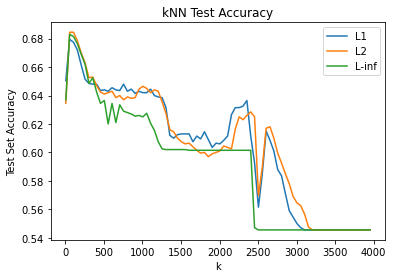

In [123]:
plot_knn_accuracies()

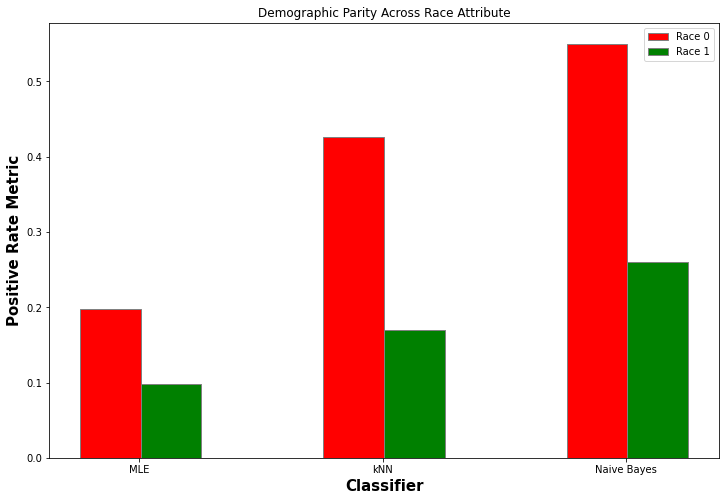

In [126]:
def plot_demographic_parity():
    mle_clf = MLE_classifier()
    mle_clf.get_predictions()
    mle_dp = mle_clf.demographic_parity()

    knn_clf = KNN_classifier()
    knn_clf.get_predictions()
    knn_dp = knn_clf.demographic_parity()

    nb_clf = NB_classifier()
    nb_clf.get_predictions()
    nb_dp = nb_clf.demographic_parity()

    # set width of bar
    barWidth = 0.25
    fig = plt.subplots(figsize =(12, 8))

    # set height of bar
    race_0_dp = [d[0] for d in [mle_dp, knn_dp, nb_dp]]
    race_1_dp = [d[1] for d in [mle_dp, knn_dp, nb_dp]]

    # Set position of bar on X axis
    br1 = np.arange(len(race_0_dp))
    br2 = [x + barWidth for x in br1]

    # Make the plot
    plt.bar(br1, race_0_dp, color ='r', width = barWidth,
            edgecolor ='grey', label ='Race 0')
    plt.bar(br2, race_1_dp, color ='g', width = barWidth,
            edgecolor ='grey', label ='Race 1')

    # Adding Xticks
    plt.title("Demographic Parity Across Race Attribute")
    plt.xlabel('Classifier', fontweight ='bold', fontsize = 15)
    plt.ylabel('Positive Rate Metric', fontweight ='bold', fontsize = 15)
    plt.xticks([r + .12 for r in range(len(race_0_dp))],
            ['MLE', 'kNN', 'Naive Bayes'])

    plt.legend()
    #plt.ylim(0, 1)

    plt.show()

plot_demographic_parity()

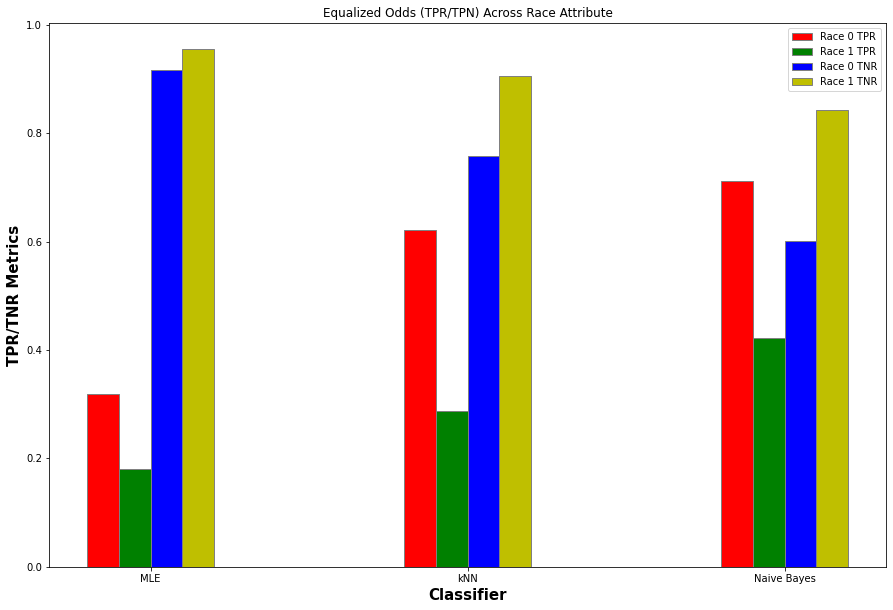

In [127]:
def plot_eo():
        mle_clf = MLE_classifier()
        mle_clf.get_predictions()
        mle_eo = mle_clf.equalized_odds()

        knn_clf = KNN_classifier()
        knn_clf.get_predictions()
        knn_eo = knn_clf.equalized_odds()

        nb_clf = NB_classifier()
        nb_clf.get_predictions()
        nb_eo = nb_clf.equalized_odds()

        # set width of bar
        barWidth = 0.1
        fig = plt.subplots(figsize =(15, 10))
        
        # set height of bar
        race_0_tpr = [d[0] for d in [mle_eo, knn_eo, nb_eo]]
        race_0_tnr = [d[1] for d in [mle_eo, knn_eo, nb_eo]]
        race_1_tpr = [d[2] for d in [mle_eo, knn_eo, nb_eo]]
        race_1_tnr = [d[3] for d in [mle_eo, knn_eo, nb_eo]]
        
        # Set position of bar on X axis
        br1 = np.arange(len(race_0_tpr))
        br2 = [x + barWidth for x in br1]
        br3 = [x + barWidth for x in br2]
        br4 = [x + barWidth for x in br3]
        
        # Make the plot
        plt.bar(br1, race_0_tpr, color ='r', width = barWidth,
                edgecolor ='grey', label ='Race 0 TPR')
        plt.bar(br2, race_1_tpr, color ='g', width = barWidth,
                edgecolor ='grey', label ='Race 1 TPR')
        plt.bar(br3, race_0_tnr, color ='b', width = barWidth,
                edgecolor ='grey', label ='Race 0 TNR')
        plt.bar(br4, race_1_tnr, color ='y', width = barWidth,
                edgecolor ='grey', label ='Race 1 TNR')
        
        # Adding Xticks
        plt.title("Equalized Odds (TPR/TPN) Across Race Attribute")
        plt.xlabel('Classifier', fontweight ='bold', fontsize = 15)
        plt.ylabel('TPR/TNR Metrics', fontweight ='bold', fontsize = 15)
        plt.xticks([r + .15 for r in range(len(race_0_tpr))],
                ['MLE', 'kNN', 'Naive Bayes'])
        
        plt.legend()
        #plt.ylim(0, 1)

        plt.show()
        
plot_eo()


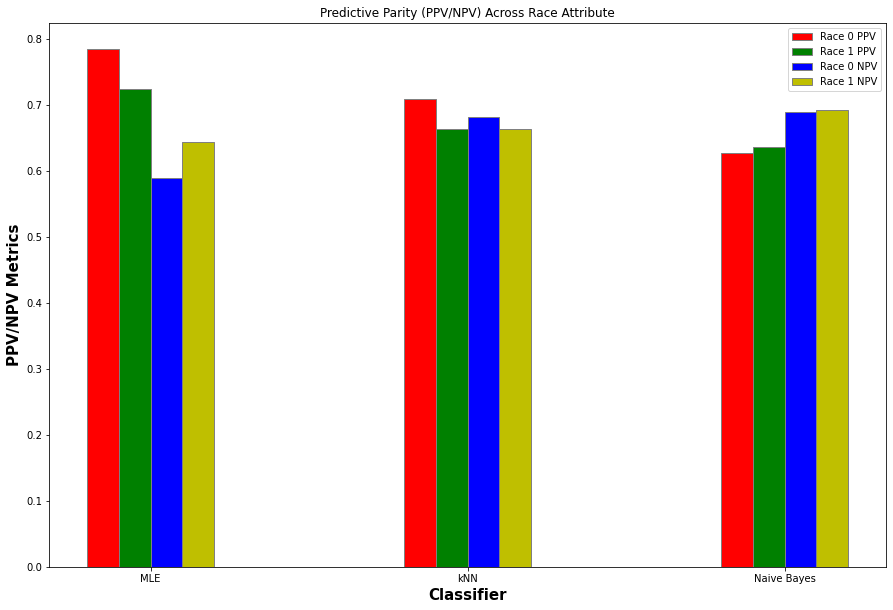

In [128]:
def plot_pp():
        mle_clf = MLE_classifier()
        mle_clf.get_predictions()
        mle_pp = mle_clf.predictive_parity()

        knn_clf = KNN_classifier()
        knn_clf.get_predictions()
        knn_pp = knn_clf.predictive_parity()

        nb_clf = NB_classifier()
        nb_clf.get_predictions()
        nb_pp = nb_clf.predictive_parity()

        # set width of bar
        barWidth = 0.1
        fig = plt.subplots(figsize =(15, 10))
        
        # set height of bar
        race_0_ppv = [d[0] for d in [mle_pp, knn_pp, nb_pp]]
        race_0_npv = [d[1] for d in [mle_pp, knn_pp, nb_pp]]
        race_1_ppv = [d[2] for d in [mle_pp, knn_pp, nb_pp]]
        race_1_npv = [d[3] for d in [mle_pp, knn_pp, nb_pp]]
        
        # Set position of bar on X axis
        br1 = np.arange(len(race_0_tpr))
        br2 = [x + barWidth for x in br1]
        br3 = [x + barWidth for x in br2]
        br4 = [x + barWidth for x in br3]
        
        # Make the plot
        plt.bar(br1, race_0_ppv, color ='r', width = barWidth,
                edgecolor ='grey', label ='Race 0 PPV')
        plt.bar(br2, race_1_ppv, color ='g', width = barWidth,
                edgecolor ='grey', label ='Race 1 PPV')
        plt.bar(br3, race_0_npv, color ='b', width = barWidth,
                edgecolor ='grey', label ='Race 0 NPV')
        plt.bar(br4, race_1_npv, color ='y', width = barWidth,
                edgecolor ='grey', label ='Race 1 NPV')
        
        # Adding Xticks
        plt.title("Predictive Parity (PPV/NPV) Across Race Attribute")
        plt.xlabel('Classifier', fontweight ='bold', fontsize = 15)
        plt.ylabel('PPV/NPV Metrics', fontweight ='bold', fontsize = 15)
        plt.xticks([r + .15 for r in range(len(race_0_tpr))],
                ['MLE', 'kNN', 'Naive Bayes'])
        
        plt.legend()
        #plt.ylim(0, 1)

        plt.show()

plot_pp()

In [135]:
def plot_acc_recall():
    mle_clf = MLE_classifier()
    (mle_metrics, mle_recall) = np.array(mle_clf.training_size_performance())

    knn_clf = KNN_classifier()
    (knn_metrics, knn_recall) = np.array(knn_clf.training_size_performance())

    nb_clf = NB_classifier()
    (nb_metrics, nb_recall) = np.array(nb_clf.training_size_performance())

    plt.plot(mle_metrics[:, 0], mle_metrics[:, 1], label='MLE-based Model')
    plt.plot(knn_metrics[:, 0], knn_metrics[:, 1], label='kNN')
    plt.plot(nb_metrics[:, 0], nb_metrics[:, 1], label='Naive Bayes')

    plt.legend()

    plt.title("Training Set Size vs Test Set Accuracy")
    plt.xlabel("Training Set Size")
    plt.ylabel("Test Set Accuracy")

    plt.figure()

    plt.plot(mle_recall[:, 0], mle_recall[:, 1], label='MLE-based Model')
    plt.plot(knn_recall[:, 0], knn_recall[:, 1], label='kNN')
    plt.plot(nb_recall[:, 0], nb_recall[:, 1], label='Naive Bayes')

    plt.legend()

    plt.title("Training Set Size vs Test Set Sensitivity")
    plt.xlabel("Training Set Size")
    plt.ylabel("Test Set Sensitivity")

    plt.figure()

<Figure size 432x288 with 0 Axes>

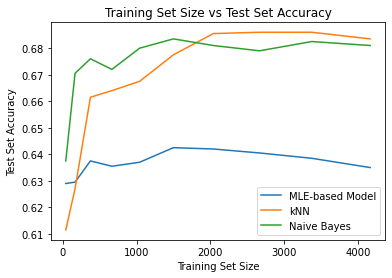

<Figure size 432x288 with 0 Axes>

In [136]:
plt.plot(mle_metrics[:, 0], mle_metrics[:, 1], label='MLE-based Model')
plt.plot(knn_metrics[:, 0], knn_metrics[:, 1], label='kNN')
plt.plot(nb_metrics[:, 0], nb_metrics[:, 1], label='Naive Bayes')

plt.legend()

plt.title("Training Set Size vs Test Set Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Test Set Accuracy")

plt.figure()

<Figure size 432x288 with 0 Axes>

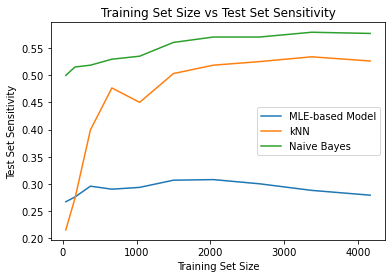

<Figure size 432x288 with 0 Axes>

In [139]:
plt.plot(mle_recall[:, 0], mle_recall[:, 1], label='MLE-based Model')
plt.plot(knn_recall[:, 0], knn_recall[:, 1], label='kNN')
plt.plot(nb_recall[:, 0], nb_recall[:, 1], label='Naive Bayes')

plt.legend()

plt.title("Training Set Size vs Test Set Sensitivity")
plt.xlabel("Training Set Size")
plt.ylabel("Test Set Sensitivity")

plt.figure()